# 1. Library & Input data

In [1]:
!pip install unidecode
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 245kB 5.7MB/s 
     |████████████████████████████████| 65.8MB 58kB/s 
     |████████████████████████████████| 81kB 3.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/My Drive/kalapa

/content/drive/My Drive/kalapa


In [8]:
import pandas as pd
import numpy as np

In [5]:
train = pd.read_csv("/content/drive/My Drive/kalapa/dataset/train.csv")
test = pd.read_csv("/content/drive/My Drive/kalapa/dataset/test.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
train.select_dtypes(exclude= 'object').shape

(53030, 136)

# 2. Feature Engineering

In [9]:
# Drop some columns are duplicated, with correlation = NaN
ignore_columns = (["gioiTinh", "info_social_sex", "ngaySinh", "namSinh"] + 
        [f"Field_{c}" for c in [14, 16, 17, 24, 26, 30, 31, 37, 52, 57]] + 
        ['partner0_K', 'partner0_L', 
         'partner1_B', 'partner1_D', 'partner1_E', 'partner1_F', 'partner1_K', 'partner1_L',
         'partner2_B', 'partner2_G', 'partner2_K', 'partner2_L',
         'partner3_B', 'partner3_C', 'partner3_F', 'partner3_G', 'partner3_H', 'partner3_K', 'partner3_L',
         *['partner4_' + i for i in 'ABCDEFGHK'],
         'partner5_B', 'partner5_C', 'partner5_H', 'partner5_K', 'partner5_L'])

# Some auto columns could make new better columns
all_auto_columns = list(set([c for c in train.columns if train[c].dtype in [np.int64, np.float64]])
                    .difference(ignore_columns + ['currentLocationLocationId', 'homeTownLocationId', 'label', 'id']))

auto_columns_1 = [c for c in all_auto_columns if 'Field_' in c]
auto_columns_2 = [c for c in all_auto_columns if 'partner' in c]
auto_columns_3 = [c for c in all_auto_columns if 'num' in c]
auto_columns_4 = [c for c in all_auto_columns if c not in auto_columns_1 + auto_columns_2 + auto_columns_3]
print(len(auto_columns_1), len(auto_columns_2), len(auto_columns_3), len(auto_columns_4), len(all_auto_columns))

37 27 12 11 87


### 2.1. Datetime columns

In [10]:
date_cols = ["Field_{}".format(i) for i in [5, 6, 7, 8, 9, 11, 15, 25, 32, 33, 35, 40]]
datetime_cols = ["Field_{}".format(i) for i in [1, 2, 43, 44]]
correct_dt_cols = ['Field_34', 'ngaySinh']
cat_cols = date_cols + datetime_cols + correct_dt_cols

# Normalize Field_34, ngaySinh
def ngaysinh_34_normalize(s):
    if s != s: return np.nan
    try: s = int(s)
    except ValueError: s = s.split(" ")[0]
    return datetime.strptime(str(s)[:6], "%Y%m")

# Normalize datetime data
def datetime_normalize(s):
    if s != s: return np.nan
    s = s.split(".")[0]
    if s[-1] == "Z": s = s[:-1]
    return datetime.strptime(s, "%Y-%m-%dT%H:%M:%S")

# Normalize date data
def date_normalize(s):
    if s != s: return np.nan
    try: t = datetime.strptime(s, "%m/%d/%Y")
    except: t = datetime.strptime(s, "%Y-%m-%d")
    return t

def process_datetime_cols(df):
    df[datetime_cols] = df[datetime_cols].applymap(datetime_normalize)  
    df[date_cols] = df[date_cols].applymap(date_normalize)
    df[correct_dt_cols] = df[correct_dt_cols].applymap(ngaysinh_34_normalize)

    # Some delta columns
    for i, j in zip('43 1 2'.split(), '1 2 44'.split()): df[f'DT_{j}_{i}'] = (df[f'Field_{j}'] - df[f'Field_{i}']).dt.seconds
    for i, j in zip('5 6 7 33 8 11 9 15 25 6 7 8 9 15 25 2'.split(), '6 34 33 40 11 35 15 25 32 7 8 9 15 25 32 8'.split()): 
        df[f'DT_{j}_{i}'] = (df[f'Field_{j}'] - df[f'Field_{i}']).dt.days
    
    # Age, month
    df['age'] = 2020 - pd.DatetimeIndex(df['ngaySinh']).year
    df['birth_month'] = pd.DatetimeIndex(df['ngaySinh']).month
    
    # Days from current time & isWeekday
    for col in cat_cols:
        name = col.split('_')[-1]
        df[f'is_WD_{name}'] = df[col].dt.dayofweek.isin(range(5))
        df[f'days_from_now_{name}'] = (datetime.now() - pd.DatetimeIndex(df[col])).days
        df[col] = df[col].dt.strftime('%m-%Y')
    
    # Delta for x_startDate and x_endDate
    for cat in ['F', 'E', 'C', 'G', 'A']:
        df[f'{cat}_startDate'] = pd.to_datetime(df[f"{cat}_startDate"], infer_datetime_format=True)
        df[f'{cat}_endDate'] = pd.to_datetime(df[f"{cat}_endDate"], infer_datetime_format=True)
        
        df[f'{cat}_start_end'] = (df[f'{cat}_endDate'] - df[f'{cat}_startDate']).dt.days
        
    for i, j in zip('F E C G'.split(), 'E C G A'.split()):
        df[f'{j}_{i}_startDate'] = (df[f'{j}_startDate'] - df[f'{i}_startDate']).dt.days
        df[f'{j}_{i}_endDate'] = (df[f'{j}_endDate'] - df[f'{i}_endDate']).dt.days
    
    temp_date = [f'{i}_startDate' for i in 'ACEFG'] + [f'{i}_endDate' for i in 'ACEFG']
    
    for col in temp_date:
        df[col] = df[col].dt.strftime('%m-%Y')
        
    for col in cat_cols + temp_date:
        df[col] = df[col]
        
    return df

### 2.2. Categorical columns

In [11]:
unicode_cols = ['Field_18', 'maCv', 'diaChi', 'Field_46', 'Field_48', 'Field_49', 'Field_56', 'Field_61', 'homeTownCity', 
                'homeTownName', 'currentLocationCity', 'currentLocationName', 'currentLocationState', 'homeTownState']
object_cols = (unicode_cols + 
               [f'Field_{str(i)}' for i in '4 12 36 38 47 62 45 54 55 65 66 68'.split()] +
               ['data.basic_info.locale', 'currentLocationCountry', 'homeTownCountry', 'brief'])

def str_normalize(s):
    s = str(s).strip().lower()
    s = re.sub(' +', " ", s)
    return s

def combine_gender(s):
    x, y = s 
    if x != x and y != y: return "nan"
    if x != x: return y.lower()
    return x.lower()

def process_categorical_cols(df):
    df['diaChi'] = df['diaChi'].str.split(',').str[-1]
    df[unicode_cols] = df[unicode_cols].applymap(str_normalize).applymap(lambda x: unidecode(x) if x==x else x)
    
    # Normalize some columns
    df["Field_38"] = df["Field_38"].map({0: 0.0, 1: 1.0, "DN": np.nan, "TN": np.nan, "GD": np.nan})
    df["Field_62"] = df["Field_62"].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "Ngoài quốc doanh Quận 7": np.nan})
    df["Field_47"] = df["Field_47"].map({"Zezo": 0, "One": 1, "Two": 2, "Three": 3, "Four": 4})
    
    # Make some new features
    df['Field_45_Q'] = df['Field_45'].str[:-3].astype('category')
    df['Field_45_TP_55'] = df['Field_45'].str[:2] == df['Field_55']
    df['is_homeTown_diaChi'] = df['homeTownCity'] == df['diaChi']
    df['is_homeTown_current_city'] = df['homeTownCity'] == df['currentLocationCity']
    df['is_homeTown_current_state'] = df['homeTownState'] == df['currentLocationState']
    df['F48_49'] = df['Field_48'] == df['Field_49']
    
    df["gender"] = df[["gioiTinh", "info_social_sex"]].apply(combine_gender, axis=1).astype("category")
    
    df[["currentLocationLocationId", "homeTownLocationId", "currentLocationLatitude", "currentLocationLongitude", 
        "homeTownLatitude", "homeTownLongitude"]].replace(0, np.nan, inplace=True) # value == 0: noisy

    df[["currentLocationLocationId", "homeTownLocationId"]] = (df[["currentLocationLocationId", "homeTownLocationId"]]
                                                             .applymap(str_normalize).astype("category"))
    df[object_cols] = df[object_cols].astype('category')
    
    return df

### 2.3. Others

In [12]:
# New feature from columns 63, 64
def process_63_64(z):
    x, y = z
    if x != x and y != y:
        return np.nan
    if (x, y) in [(1.0, 2.0), (2.0, 3.0), (3.0, 4.0), (4.0, 8.0), (7.0, 5.0), (5.0, 6.0), (9.0, 43.0), (8.0, 9.0)]: return True
    else: return False
    
def process_others(df):        
    df[["Field_27", "Field_28"]].replace(0.0, np.nan, inplace=True)
    df['F18_isnumeric'] = df['Field_18'].str.isnumeric()
    df['F18_isalpha'] = df['Field_18'].str.isalpha()
    
    # Delta from some pairs of columns
    for i, j in [(20, 27), (28, 27), (39, 41), (41, 42), (50, 51), (51, 53)]:
        df[f'F{str(i)}_{str(j)}_delta'] = df[f'Field_{str(j)}'] - df[f'Field_{str(i)}']
    df['F_59_60'] = df['Field_59'] - df['Field_60'] - 2
    df['F_63_64'] = df[['Field_63', 'Field_64']].apply(process_63_64, axis=1).astype('category')
    
    # Mean, std from partnerX columns
    for i in '1 2 3 4 5'.split():
        col = [c for c in df.columns if f'partner{i}' in c]
        df[f'partner{i}_mean'] = df[col].mean(axis=1)
        df[f'partner{i}_std'] = df[col].std(axis=1)

    # Reference columns
    columns = set(df.columns).difference(ignore_columns)
    df['cnt_NaN'] = df[columns].isna().sum(axis=1)
    df['cnt_True'] = df[columns].applymap(lambda x: isinstance(x, bool) and x).sum(axis=1)
    df['cnt_False'] = df[columns].applymap(lambda x: isinstance(x, bool) and not x).sum(axis=1)

    # Combinations of auto columns
    lst_combination = (list(combinations(auto_columns_2, 2)) + list(combinations(auto_columns_3, 2)) + list(combinations(auto_columns_4, 2)))
    for l, r in lst_combination:
        for func in 'add subtract divide multiply'.split():
            df[f'auto_{func}_{l}_{r}'] = getattr(np, func)(df[l], df[r])
            
    return df

### 2.4. Combine all parts

In [13]:
def transform(df):
    df = process_datetime_cols(df)
    df = process_categorical_cols(df)
    df = process_others(df)
    return df.drop(ignore_columns, axis=1)

train = train.sample(frac=1).reset_index(drop=True)
train = transform(train)
test = transform(test)

NameError: ignored

## Datetime preprocessing - Add some columns

### 2.5. Try Count Encoding

In [ ]:
#Support catboost modelling
#take categorical columns
cat_features = [c for c in train.columns if (train[c].dtype not in [np.float64, np.int64])]
train[cat_features] = train[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)

In [ ]:
# Create the encoder
t = pd.concat([train, test]).reset_index(drop=True)
count_enc = ce.CountEncoder().fit_transform(t[cat_features])
tt = t.join(count_enc.add_suffix("_count"))

f2_train = tt.loc[tt.index < train.shape[0]]
f2_test = tt.loc[tt.index >= train.shape[0]]

columns = sorted(set(f2_train.columns).intersection(f2_test.columns))
print(len(columns))

2220


In [ ]:
f2_train.shape

(53030, 2220)

In [ ]:
f2_test.shape

(20381, 2220)

# 3. Modelling

In [ ]:
gini, feature_importance_df = {}, pd.DataFrame()

TRAIN, TEST = f2_train[columns].drop(['id', 'label'], axis=1), f2_test[columns].drop(['id', 'label'], axis=1)
LABEL = f2_train['label']
preds, oof_preds = np.zeros(TRAIN.shape[0]), {}

cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_idx, val_idx) in enumerate(cv.split(TRAIN, LABEL)):
    X_train, y_train = TRAIN.iloc[train_idx], LABEL.iloc[train_idx]
    X_val, y_val = TRAIN.iloc[val_idx], LABEL.iloc[val_idx]

    gbm = CatBoostClassifier(eval_metric='AUC', 
                             use_best_model=True,
                             iterations=1000, 
                             task_type="GPU",
                             learning_rate=0.075,                              
                             boosting_type='Plain',
                             gpu_ram_part=0.75,
                             max_ctr_complexity=1,
                             random_seed=1998).fit(X_train, y_train, 
                                                 cat_features=set(cat_features),
                                                 eval_set=(X_val, y_val), verbose=500)

    y_pred = gbm.predict(X_val)
    y_pred_proba = gbm.predict_proba(X_val)[:, 1]
        
    preds[val_idx] = y_pred_proba
    oof_preds[f'F{i+1}'] = gbm.predict_proba(TEST)[:, 1]
    
    gini[f'F{i+1}'] = 2 * roc_auc_score(y_val, y_pred_proba) - 1
    
    # For create feature importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = TRAIN.columns
    fold_importance_df["importance"] = gbm.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d GINI : %.5f' % (i + 1, 2*roc_auc_score(y_val, y_pred_proba) - 1))
    
# Resulting
roc_auc = roc_auc_score(LABEL, preds)
print('Avg GINI score:', 2*roc_auc - 1)

result = np.array(list(gini.values()))

CatBoostError: ignored

In [ ]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
 
    # sort rows on prediction column
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:, 0].argsort()][::-1, 0]
    pred_order = arr[arr[:, 1].argsort()][::-1, 0]
 
    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1. / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1. / np.sum(pred_order)
    L_ones = np.linspace(1 / n_samples, 1, n_samples)
 
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
 
    # normalize to true Gini coefficient
    return G_pred * 1. / G_true
 
def lgb_gini(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'gini', Gini(y_true, y_pred), True

ValueError: ignored

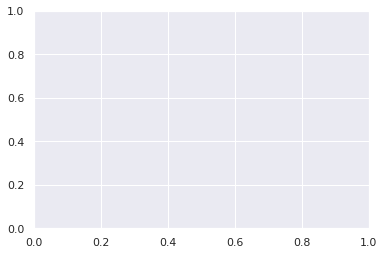

In [ ]:

TRAIN, TEST = f2_train[columns].drop(['id', 'label'], axis=1), f2_test[columns].drop(['id', 'label'], axis=1)
LABEL = f2_train['label']
preds, test_preds, gini = np.zeros(TRAIN.shape[0]), {}, {}
feature_importance_df = pd.DataFrame()

###
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fold_aucs = []
fig, ax = plt.subplots()

###


cv = StratifiedKFold(n_splits=5, shuffle=True)
for i, (train_idx, val_idx) in enumerate(cv.split(TRAIN, LABEL)):
    X_train, y_train = TRAIN.iloc[train_idx], LABEL.iloc[train_idx]
    X_val, y_val = TRAIN.iloc[val_idx], LABEL.iloc[val_idx]

#     model = CatBoostClassifier(eval_metric='AUC', 
#                              use_best_model=True,
#                              iterations=1000, 
#                              learning_rate=0.1, 
#                              random_seed=42).fit(X_train, y_train, 
#                                                  cat_features=set(cat_features),
#                                                  eval_set=(X_val, y_val), verbose=500)

###
    model = lgb.LGBMClassifier(
              nthread=4,
              n_estimators=10000,
              learning_rate=0.02,
              num_leaves=128,
              colsample_bytree=0.9497036,
              subsample=0.8715623,
              max_depth=8,
              reg_alpha=0.041545473,
              reg_lambda=0.0735294,
              min_split_gain=0.0222415,
              min_child_weight=39.3259775,
              silent=-1            
              )

    model.fit(X_train, y_train, categorical_feature=set(cat_features), verbose = -1)
    #model = LGBMClassifier(eval_metric='AUC', 
#                              use_best_model=True,
    #                         iterations=1000, 
    #                         learning_rate=0.03).fit(X_train, y_train)
    #                                              categorical_feature=set(cat_features))
###

    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
        
    preds[val_idx] = y_pred_proba
    test_preds[f'F{i+1}'] = model.predict_proba(TEST)[:, 1]
    
    gini[f'F{i+1}'] = 2 * roc_auc_score(y_val, y_pred_proba) - 1
    
###
    
    auc_ = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    fold_aucs.append(auc_)
    print(f"val AUC = {auc_:.4f}")


    viz = plot_roc_curve(model, X_val, y_val, name=f"ROC Fold {i}", alpha=0.3, lw=1, ax=ax)
    
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    
    # For create feature importances
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = TRAIN.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d GINI : %.5f' % (i + 1, 2*roc_auc_score(y_val, y_pred_proba) - 1))

In [ ]:
   
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# fig1, ax1 = plt.subplots()
# ax1.plot(
#     mean_fpr,
#     mean_tpr,
#     color="b",
#     label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
#     lw=2,
#     alpha=0.8,
# )
# ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curves", ylabel='True Possitive Rate', xlabel='False Possitive Rate')
# ax1.legend(loc="lower right")
# plt.savefig("roc_mean.png")

ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.3f $\pm$ %0.3f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="CatBoost ROC Curve")
ax.legend(loc="lower right")
plt.savefig("roc.png")
###
    
# Resulting
roc_auc = roc_auc_score(LABEL, preds)
print('Avg GINI score:', 2*roc_auc - 1)

result = np.array(list(gini.values()))
print('GINI: {:.5f} +- {:.5f}'.format(result.mean(), result.std()))

In [ ]:
import joblib


joblib.dump(model,'model.pkl')


In [ ]:
loaded_model = joblib.load('./model.pkl')

In [ ]:
from sklearn.metrics import classification_report

y_pred = loaded_model.predict(TRAIN)



In [ ]:
print(classification_report(LABEL, y_pred, labels=[0, 1]))

In [ ]:
with open('classification_report.txt', 'w') as f:
    for i in classification_report(LABEL, y_pred, labels=[0, 1]):
        f.write(str(i))

In [ ]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:30].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('CatBoost Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('importance.png')

display_importances(feature_importance_df_=feature_importance_df)

# 4. Submisison

In [ ]:
test['label'] = pd.DataFrame(test_preds).mean(axis=1).values
test[['id', 'label']].to_csv('submission.csv', index=False)